<a href="https://colab.research.google.com/github/msiplab/AtipWork/blob/master/python/sample_anls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 非負値行列分解演習

Copyright (C) 2025 Shogo MURAMATSU, All rights reserved

準備


In [12]:

%pip install pandas
%pip install japanize-matplotlib
%pip install librosa

### パラメータ設定

- 冗長率 (Redundancy ratio)
- 正則化パラメータ(Regularization parameter)
- 繰返し回数 (Number of iterations)

In [13]:
# 冗長度
redundancyRatio = 1/8

# 正則化パラメータλ
lmd = 1000

# 繰り返し回数
nItersAnls = 2000

## 音響データからのデータ行列 $\mathbf{Y}$の生成

-  $\mathbf{Y}\in {\mathbb{R}}^{N\times S}$

サンプリングレート: 22050 Hz


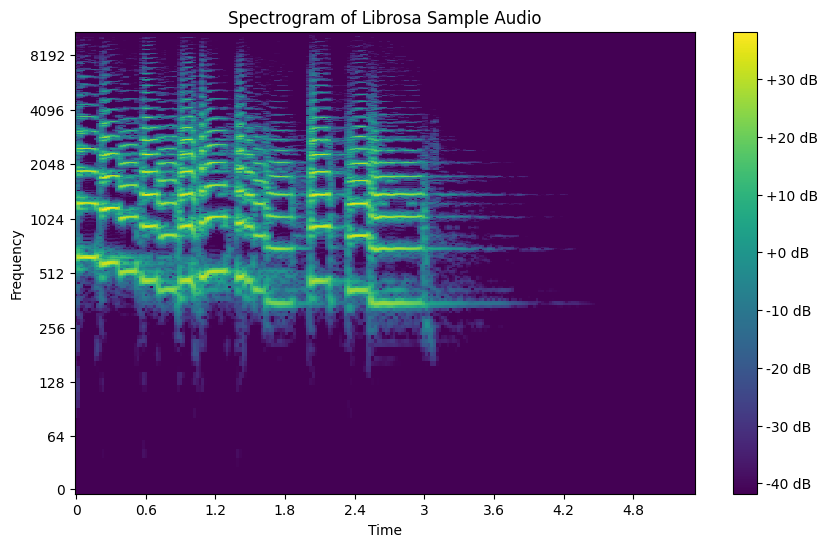

スペクトログラムのサイズ: (1025, 230)


In [14]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Librosa付属の音声データをロード
y, sr = librosa.load(librosa.ex('trumpet'))
print(f"サンプリングレート: {sr} Hz")

# スペクトログラムの計算
S = librosa.stft(y)  # 短時間フーリエ変換
Y = np.abs(S)  # 振幅スペクトル
Y_db = librosa.amplitude_to_db(Y)  # 振幅をdBスケールに変換

# スペクトログラムのプロット
plt.figure(figsize=(10, 6))
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Librosa Sample Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# スペクトログラムのサイズを表示
print(f"スペクトログラムのサイズ: {Y_db.shape}")

### 非負値因子分解(NMF)

#### 問題設定:

$$
\begin{aligned}
& \left\{\widehat{\mathbf{D}},\left\{\hat{\mathbf{x}}_n\right\}\right\}=\arg \min _{\left\{\boldsymbol{D},\left\{x_n\right\}\right\}} \frac{1}{S} \sum_{n=1} \frac{1}{2}\left\|\mathbf{y}_n-\boldsymbol{D} \boldsymbol{x}_n\right\|_2^2+\lambda\left\|\boldsymbol{x}_n\right\|_1 \\
& \text { s.t. }[\boldsymbol{D}]_{i, j} \geq 0,\left[\boldsymbol{x}_n\right]_j \geq 0
\end{aligned}
$$

#### アルゴリズム:

非負値スパース近似ステップと非負値辞書更新ステップを繰返す．

-  非負値スパース近似ステップ


$$
\boldsymbol{X}^{\mathrm{T}} \leftarrow \boldsymbol{X}^{\mathrm{T}} \odot \mathcal{P}_{+}\left(\mathbf{Y}^{\mathrm{T}} \widehat{\mathbf{D}}^{\mathrm{T}}\right) \oslash\left(\boldsymbol{X}^{\mathrm{T}} \widehat{\mathbf{D}} \widehat{\mathbf{D}}^{\mathrm{T}}+\lambda \mathbf{1}\right)
$$

-  非負値辞書更新ステップ


$$
\boldsymbol{D} \leftarrow \boldsymbol{D} \odot \mathcal{P}_{+}\left(\mathbf{Y} \widehat{\mathbf{X}}^{\mathrm{T}}\right) \oslash\left(\boldsymbol{D} \widehat{\mathbf{X}} \widehat{\mathbf{X}}^{\mathrm{T}}\right)
$$

In [15]:
# Y の行数
nDims = Y.shape[0]

# アトムの数
nAtoms = np.ceil(redundancyRatio * nDims).astype(int)

print(f"アトムの数: {nAtoms}")
print(f"正則化パラメータλ: {lmd}")

アトムの数: 129
正則化パラメータλ: 1000


辞書 ${\mathbf{D} }$ の初期化

-  Nonnegative Double Singular Value Decomposition (NNDSVD)

(参考文献)
C. Boutsidis, E. Gallopoulos,
SVD based initialization: A head start for nonnegative matrix factorization, Pattern Recognition, Volume 41, Issue 4, 2008, Pages 1350-1362, ISSN 0031-3203, https://doi.org/10.1016/j.patcog.2007.09.010. (https://www.sciencedirect.com/science/article/pii/S0031320307004359)



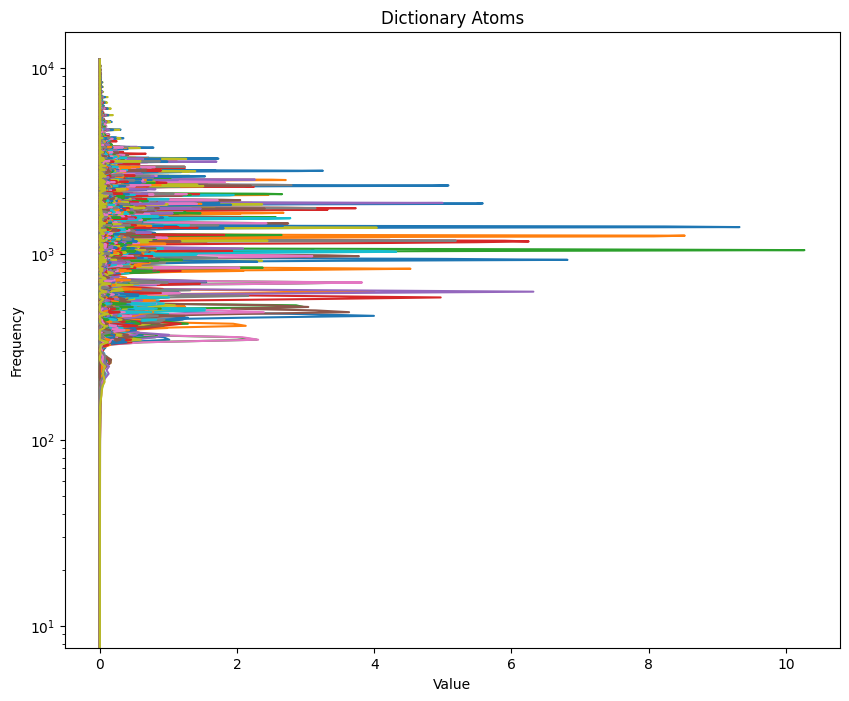

In [16]:
# NNDSVDによる初期化
nSamples = Y.shape[1]
U, Sigma, VT = np.linalg.svd(Y, full_matrices=False)
W = np.zeros((nDims, nAtoms))
H = np.zeros((nAtoms, nSamples))

# 初めのベクトルを設定
W[:, 0] = np.sqrt(Sigma[0]) * np.abs(U[:, 0])
H[0, :] = np.sqrt(Sigma[0]) * np.abs(VT[0, :])

# 残りのベクトルを設定
for i in range(1, min(nAtoms, U.shape[1], VT.shape[0])):
    uu = U[:, i]
    vv = VT[i, :]
    uup = np.maximum(uu, 0)
    uun = np.maximum(-uu, 0)
    vvp = np.maximum(vv, 0)
    vvn = np.maximum(-vv, 0)
    norm_uup = np.linalg.norm(uup)
    norm_vvp = np.linalg.norm(vvp)
    norm_uun = np.linalg.norm(uun)
    norm_vvn = np.linalg.norm(vvn)
    termp = norm_uup * norm_vvp
    termn = norm_uun * norm_vvn
    if termp > termn:
        W[:, i] = np.sqrt(Sigma[i] * termp) * uup / norm_uup
        H[i, :] = np.sqrt(Sigma[i] * termp) * vvp / norm_vvp
    else:
        W[:, i] = np.sqrt(Sigma[i] * termn) * uun / norm_uun
        H[i, :] = np.sqrt(Sigma[i] * termn) * vvn / norm_vvn
D = W
X = H

# 初期辞書を表示
plt.figure(figsize=(10, 8))
for i in range(D.shape[1]):
    plt.plot(D[:, i], (sr/2)*np.arange(D.shape[0])/D.shape[0], label=f'Atom {i+1}')
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title('Dictionary Atoms')
plt.show()

### 非負値最小二乗法

#### 問題設定：
$$
\widehat{\mathbf{A}}=\arg \min _{\boldsymbol{A}} \left\|\mathbf{Y}-\boldsymbol{A} \mathbf{B}^\intercal\right\|_F^2\ \text { s.t. }[\boldsymbol{A}]_{i, j} \geq 0,\left[\mathbf{B}\right]_{n,j} \geq 0
$$

#### 乗法更新法：
$$
\boldsymbol{A} \leftarrow \boldsymbol{A} \odot \mathcal{P}_{+}\left(\mathbf{Y} {\mathbf{B}}\right) \oslash\left(\boldsymbol{A} {\mathbf{B}}^\intercal\mathbf{B}\right)
$$

In [17]:
def non_negative(X):
    return np.maximum(X, 0)

def multiplicative_update(A, B, Y, lmd=0):
    """
    与えられた式を使用して行列Aを更新します。
    パラメータ:
    A (numpy.ndarray): 更新する行列A
    Y (numpy.ndarray): 行列Y
    B (numpy.ndarray): 行列B
    lmd (float): 正則化パラメータλ
    戻り値:
    numpy.ndarray: 更新された行列A
    """
    # ゼロ割を防ぐための微小値
    eps = 1e-12

    # Check if the dimensions of Y and A @ B.T match
    if Y.shape != (A @ B.T).shape:
        raise ValueError("The dimensions of Y and A @ B.T do not match.")

    # Check if lmd is non-negative
    if lmd < 0:
        raise ValueError("Regularization parameter lmd must be non-negative.")

    # Update A
    A = A * non_negative(Y @ B) / (A @ (B.T @ B)+lmd+eps)
    return A

#### 交互ステップの繰返し計算

In [18]:
# 非負値交互最小二乗法(ANLS)
cost = np.zeros(nItersAnls)

for iIter in range(nItersAnls):
    print(f"\rIteration {iIter+1}/{nItersAnls}",end='',flush=True)

    # 非負値スパース近似
    X = multiplicative_update(X.T, D, Y.T, lmd).T

    # 非負値辞書更新
    D = multiplicative_update(D, X.T, Y)

    # コスト関数の計算
    cost[iIter] = np.linalg.norm(Y - D @ X, 'fro')**2/(2*nSamples)
print(f"{cost[-1]:6.2f} ANLS終了")

Iteration 2000/2000 11.64 ANLS終了


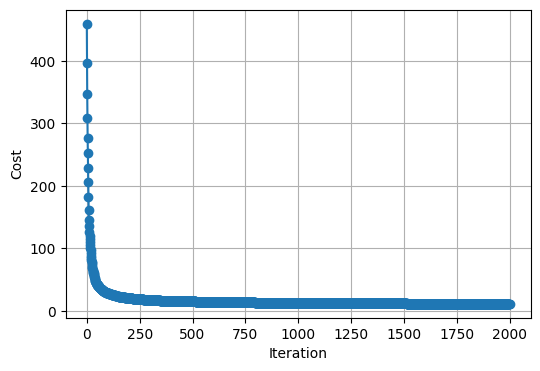

In [19]:
# コスト評価のグラフ
plt.figure(figsize=(6, 4))
plt.plot(cost, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.grid()
plt.show()

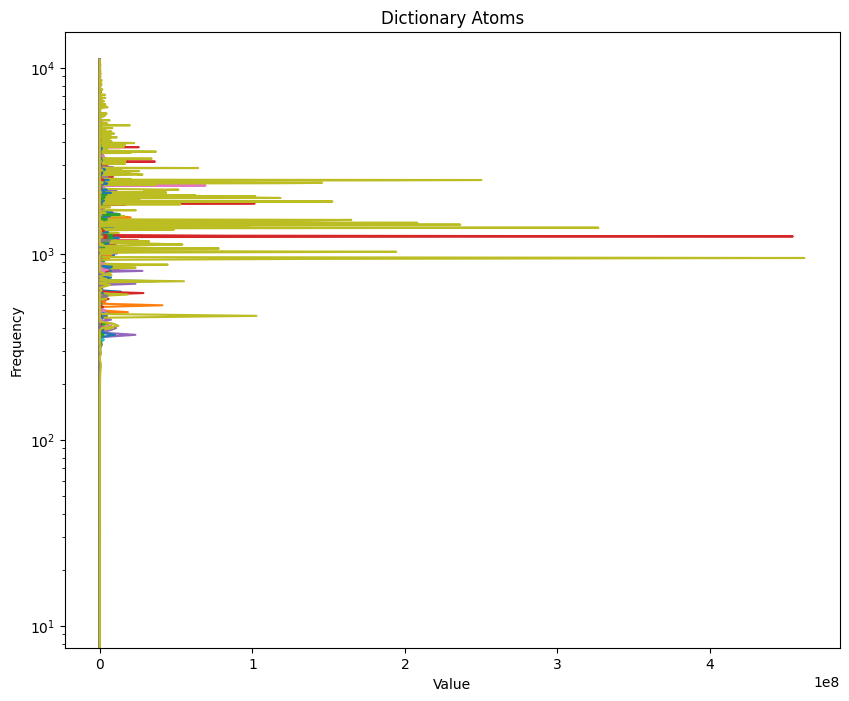

In [20]:
# 学習辞書を表示
plt.figure(figsize=(10, 8))
for i in range(D.shape[1]):
    plt.plot(D[:, i], (sr/2)*np.arange(D.shape[0])/D.shape[0], label=f'Atom {i+1}')
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title('Dictionary Atoms')
plt.show()

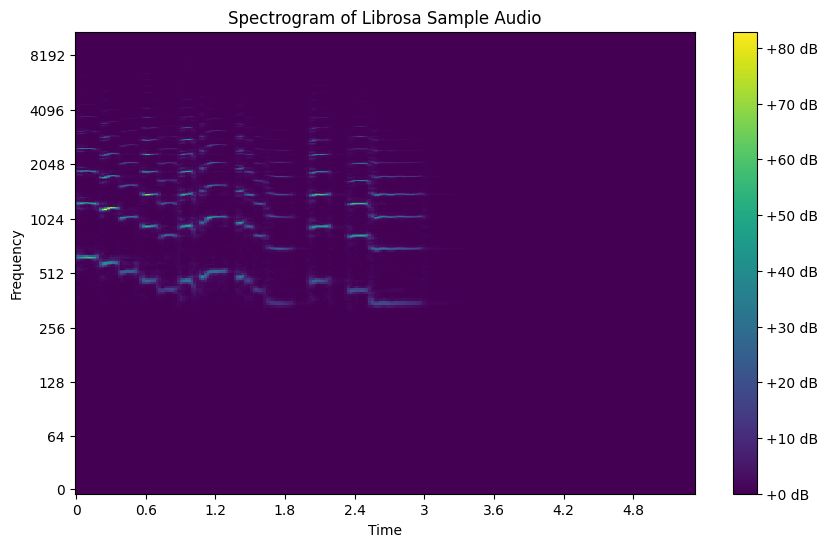

In [21]:
# スペクトログラムのプロット
plt.figure(figsize=(10, 6))
librosa.display.specshow(D@X, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Librosa Sample Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


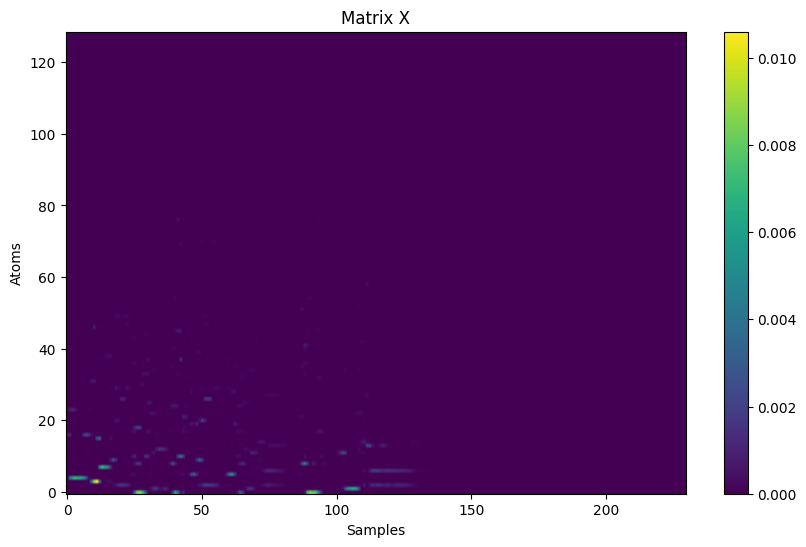

In [22]:
# Xを画像としてプロット
plt.figure(figsize=(10, 6))
plt.imshow(X, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Matrix X')
plt.xlabel('Samples')
plt.ylabel('Atoms')
plt.show()